In [2]:
import sqlite3
import pandas as pd
import numpy as np
import os
import sys
parent = os.path.realpath(os.path.join(os.path.abspath(''), os.pardir))
sys.path.append(parent)
from packages.periodic_table import ptable_plotter
from databases.sql_connect import create_connection
DB_CORR = os.path.join(parent,"databases", "TEMPRO_DB220519_Corr.db")
assert(os.path.exists(DB_CORR))



In [3]:
def get_materials_data(indicator):
    conn = create_connection(DB_CORR)
    CATEGORY = indicator
    query = 'SELECT * FROM [1000LCAResults]'
    df = pd.read_sql_query(query, conn)
    df = df[df["Category"] == CATEGORY]
    query = 'SELECT * FROM [1000Materials]'
    df_symbols = pd.read_sql_query(query, conn)
    df_symbols.set_index("ID", inplace=True)
    conn.close()

    df_symbols["Val"] = np.nan
    for i in df_symbols.index:
        if i in list(df["ProductSystemID"]):
            val = list(df[df["ProductSystemID"] == i]["Result"])[0]
            if val < 0:
                val = 0
            df_symbols.at[i, "Val"] = list(
                df[df["ProductSystemID"] == i]["Result"])[0]
    df_symbols = df_symbols[df_symbols["Symbol"] != "U"]
    df_symbols.set_index("Symbol", inplace=True)
    materials = pd.read_csv(
        "periodic_table.csv", names=["Symbol", "Val"])
    materials.set_index("Symbol", inplace=True)
    materials["NewVal"] = 0
    for s in materials.index:
        if s in df_symbols.index:
            materials.at[s, "NewVal"] = df_symbols.loc[s]["Val"]

    materials.drop(columns=["Val"], inplace=True)
    materials = materials[materials["NewVal"] > 0]
    name = f"results_{CATEGORY}.csv"
    materials.to_csv(name, header=False)
    return name


In [4]:
from bokeh.io import export_png
cats = {"EI-Minerals- Total": "ADP - Economic Importance [kg Sb-eq]",
        "GPR-Minerals- Total": "Geo-Political Suppy Risk [1]",
        "CED - total": "Primary Energy Demand [MJ-eq]",
        "CExD - metals": "Primary Exergy Demand [MJ-eq]",
        "ReCiPe Midpoint (E) - metal depletion (MDP)": "Metal Depletion Potential [kg Fe-eq]",
        "ADP": "Abiotic Depletion Potential [kg Sb-eq]",
        "ReCiPe Endpoint (E - A) - total (total)": "ReCiPe-Total Impacts",
        "CML-climate change (GWP 100a)": "Greenhouse Emissions [kg CO2-eq]"}
from bokeh.io import export_svg
for k, v in cats.items():
    filename = get_materials_data(k)
    p = ptable_plotter(filename,
                   log_scale=True,
                   #output_filename=f"PT-{v}.html",
                   title=v,
                   show = False,
                   cmap="viridis")
    p.output_backend="svg"

    export_svg(p, filename=f"{k}.svg")


ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : text_font='Times New Roman' [no close matches] {renderer: GlyphRenderer(id='p1069', ...)}
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : text_font='Times New Roman' [no close matches] {renderer: GlyphRenderer(id='p1060', ...)}
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : text_font='Times New Roman' [no close matches] {renderer: GlyphRenderer(id='p1256', ...)}
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a missp

In [5]:
cats_short = {"EI-Minerals- Total": "ADP-EI",
              "GPR-Minerals- Total": "GPSR",
              "CED - total": "CED",
              "CExD - metals": "CExD",
              "ReCiPe Midpoint (E) - metal depletion (MDP)": "MDP",
              "ADP": "ADP",
              "ReCiPe Endpoint (E - A) - total (total)": "Total",
              "CML-climate change (GWP 100a)": "GWP"}
path = os.getcwd()
df_ = []
for k, v in cats_short.items():
    file = os.path.join(path, f"results_{k}.csv")
    df = pd.read_csv(file)
    df.columns = ["Symbol", k]
    df.set_index("Symbol", inplace=True)
    df_.append(df)


In [6]:
path = os.getcwd()
df_ = []
for k, v in cats_short.items():
    file = os.path.join(path, f"results_{k}.csv")
    df = pd.read_csv(file)
    df.columns = ["Symbol", k]
    df.set_index("Symbol", inplace=True)
    df_.append(df)


parent = print(os.path.dirname(path))
data_adp =os.path.join(os.path.dirname(path),"1_Indicators", "ADP_expanded.xlsx")
df_adp = pd.read_excel(data_adp, engine="openpyxl", sheet_name="ADP-Elements")
df_adp = df_adp[['Symbol', 'Category']]
df_adp.dropna(inplace=True)

for col in df_adp.columns:
    try:
        df_adp[col] = df_adp[col].str.replace(
            'Iron and Ferro-Alloys', 'Ferrous')
    except:
        pass
df_adp.set_index("Symbol", inplace=True)
df_.append(df_adp)
df_impacts = pd.concat(df_, axis=1)
df_impacts.to_csv("total_results.csv")
df_impacts.rename(columns = cats_short, inplace=True)
df_impacts

c:\Users\fpenaherrera_vaca\Documents\UOL-ownCloud\Diss\DataEvaluation


,ADP-EI,GPSR,CED,CExD,MDP,ADP,Total,GWP,Category
Symbol,,,,,,,,,
Be,0.022706,219600.333379,18942.055360,41.513992,17.928018,9.042425,190.339546,1078.665487,Other
Al,0.000150,15977.963484,164.107858,0.310656,0.160613,0.064818,2.625953,10.242067,Base Metals
Ca,0.000133,1037.021690,199.381552,0.318206,0.155928,0.086105,3.348692,12.720839,Other
Sc,0.043100,337329.587510,76366.295330,113.358319,55.681504,33.008400,1276.995539,4061.052021,REE
V,0.000298,2118.277602,468.895519,0.751171,0.362114,0.202682,7.864601,24.970685,Ferrous
...,...,...,...,...,...,...,...,...,...
N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other
O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other
K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other


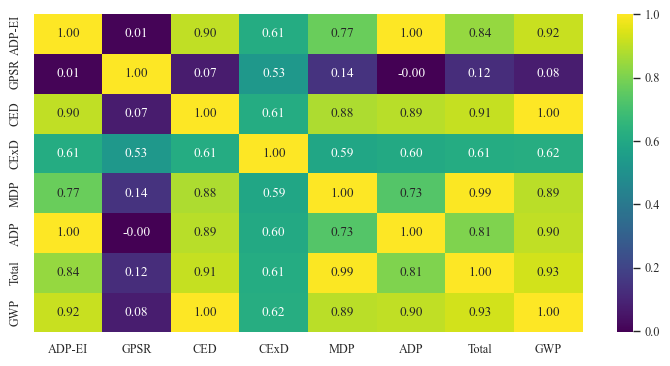

In [7]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme()
sns.set(context="paper", style="darkgrid", font="Times New Roman")
cm = 1/2.54 * 1.5
fig, ax = plt.subplots(figsize=(15*cm, 7*cm))
df_heat_map = df_impacts.drop(["Category"], axis=1)
#df_heat_map.set_index("Symbol", inplace=True)
df_corr = df_heat_map.corr()
sns.heatmap(data=df_corr, cmap="viridis", annot=True, fmt=".2f", ax=ax)
fig.savefig("heatmap_materials.svg", bbox_inches='tight', dpi=600)

In [8]:
full_label = {cats_short[v]:cats[v] for v in cats.keys()}
full_label

{'ADP-EI': 'ADP - Economic Importance [kg Sb-eq]',
 'GPSR': 'Geo-Political Suppy Risk [1]',
 'CED': 'Primary Energy Demand [MJ-eq]',
 'CExD': 'Primary Exergy Demand [MJ-eq]',
 'MDP': 'Metal Depletion Potential [kg Fe-eq]',
 'ADP': 'Abiotic Depletion Potential [kg Sb-eq]',
 'Total': 'ReCiPe-Total Impacts',
 'GWP': 'Greenhouse Emissions [kg CO2-eq]'}

C:\Users\fpenaherrera_vaca\AppData\Local\Temp\ipykernel_21400\25285820.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


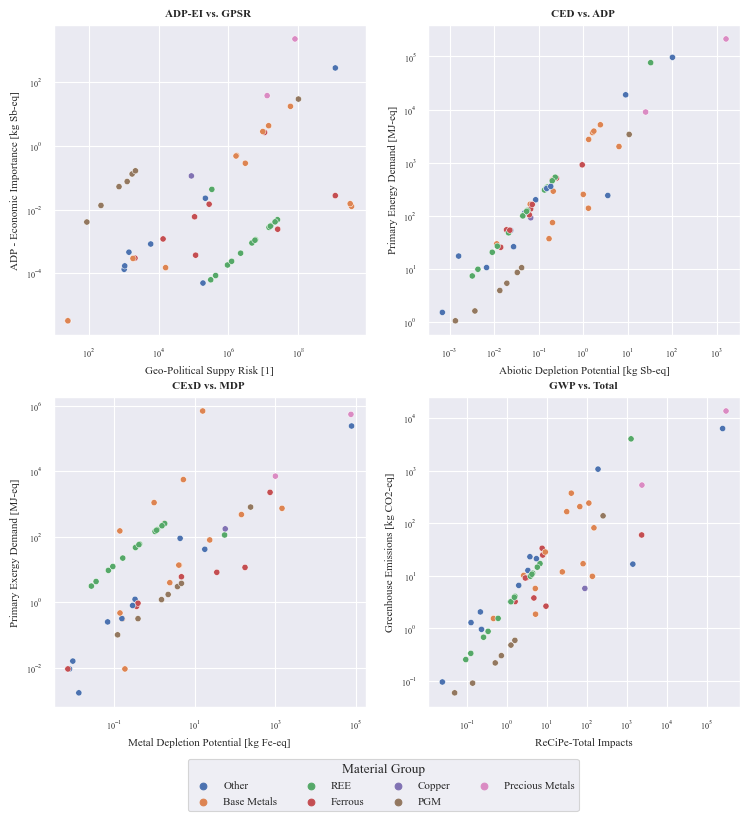

In [9]:
import seaborn as sns
pairs = [("ADP-EI", "GPSR"),
         ("CED", "ADP"),
         ("CExD", "MDP"),
         ("GWP", "Total"),]

FONT_SMALL=8
fig, axs_ = plt.subplots(2, 2, figsize=(15*cm, 15*cm))

axs = [axs_[0][0],axs_[0][1],axs_[1][0],axs_[1][1]]
for i,pair in enumerate(pairs):
    ax = axs[i]
    ax.set_title(f"{pair[0]} vs. {pair[1]} ", fontweight='bold',fontsize=FONT_SMALL)
    sns.scatterplot(data=df_impacts, y=pair[0], x=pair[1],
                    hue="Category", ax=ax, s=20)

    ax.set_xlabel(full_label[pair[1]], fontsize=FONT_SMALL)
    ax.set_ylabel(full_label[pair[0]], fontsize=FONT_SMALL)
    ax.set_yscale('log')
    ax.set_xscale('log')
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FONT_SMALL*0.75)
    if i !=3:
        ax.get_legend().remove()
    if i == 3:
        ax.legend(fontsize=FONT_SMALL, 
                  title="Material Group",
                   ncol=4,
              bbox_to_anchor=(0.5, -0.15))
fig.show()

fig.savefig("scatter_plots.svg", bbox_inches='tight',dpi=600)

In [25]:
#Validate GWP
df_GWP = pd.read_excel("validation.xlsx", engine="openpyxl", sheet_name="GWP", index_col="Symbol")
df_GWP["Updated"] = np.nan
res_GWP =pd.read_csv("results_CML-climate change (GWP 100a).csv", header= None) 

res_GWP.columns= ["Symbol", "GWP"]
res_GWP.set_index("Symbol", inplace=True)

for idx, row in df_GWP.iterrows():
    df_GWP.at[idx,"Updated"] = res_GWP.at[idx,"GWP"]
    if idx == "Pd":
        df_GWP.at[idx,"Updated"]*= 1/(0.0710+0.00059)
df_GWP.columns = ["[NE14]", "[We16]", "Updated"]

In [26]:
# Validate GWP
# Need to recheck the flows
df_CED = pd.read_excel("validation.xlsx", engine="openpyxl", sheet_name="CED", index_col="Symbol")
df_CED["Updated"] = np.nan
res_CED =pd.read_csv("results_CED - total.csv", header= None) 

res_CED.columns= ["Symbol", "CED"]
res_CED.set_index("Symbol", inplace=True)

for idx, row in df_CED.iterrows():
    df_CED.at[idx,"Updated"] = res_CED.at[idx,"CED"]
    if idx == "Pd":
        df_CED.at[idx,"Updated"]*= 1/(0.0710+0.00059)

df_CED.columns = ["[NE14]", "[We16]", "Updated"]